## LINE通知Bot

In [509]:
#LINE BOT  ON

import requests

class LINENotifyBot(object):
    API_URL = 'https://notify-api.line.me/api/notify'
    def __init__(self, access_token):
        self.__headers = {'Authorization': 'Bearer ' + access_token}

    def send(
        self,
        message,
        image=None,
        sticker_package_id=None,
        sticker_id=None,
    ):
        payload = {
            'message': message,
            'stickerPackageId': sticker_package_id,
            'stickerId': sticker_id,
        }
        files = {}
        if image != None:
            files = {'imageFile': open(image, 'rb')}
        r = requests.post(
            LINENotifyBot.API_URL,
            headers=self.__headers,
            data=payload,
            files=files,
        )
print("LINE BOTを起動します.")

LINE BOTを起動します.


# Q学習


In [510]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



## Config

In [511]:
from torch import nn
# 定数の設定
ENV = 'RoombaEnv-v0'  # 使用する課題名
MAX_STEPS = 600  # 1試行のstep数
NUM_EPISODES = 30000  # 最大試行回数

ALPHA = 0.0001 # 学習率
GAMMA = 0.99  # 時間割引率
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
CAPACITY = 10000
MODELS =""
CRITERION = nn.SmoothL1Loss()
UPDATE_FREQ = 12000 #step
NOTIFI = True
CURRICULUM = False

NUM_DIZITIZED = 100
NUM_PLANNING_STEPS = 100

anguler_variation = 0.246 # Roombaのモデル (rad)

memory_loss = []
update_count = []

memory_step = []
sum_reward = []
memory_reward_mean = []
episode_count = []
memory_distance = []
memory_theta = []

## Tensorboard 設定
ex. tensorboard --logdir [logs へのパス]


In [512]:
# from torch.utils.tensorboard import SummaryWriter

# # log_dirでlogのディレクトリを指定
# writer = SummaryWriter(log_dir="./logs")

## 準備

In [513]:
import os
import shutil

target_dir = 'img_Q'

shutil.rmtree(target_dir)
os.mkdir(target_dir)

In [514]:
# namedtupleを生成
from collections import namedtuple
 
Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

## Roomba simulator

In [515]:
import numpy as np
import random
import cv2

import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class RoombaSimulator:
    def __init__(self):
        self.world_pos_position = [0, 0]  # 初期位置 [x, y]
        self.world_pos_position_pre = [0, 0]
        self.ball_pos_position = [0, 0]  # ボールの初期位置 [x, y]
        self.odometry_position = [0, 0]  # オドメトリ
        self.odometry_position_pre = [0, 0]

        self.world_orientation = 0   # 初期姿勢 (rad)
        self.orientation = 0

        self.left_wheel_rotation = 0  # 左車輪の回転角度 (rad)
        self.right_wheel_rotation = 0  # 右車輪の回転角度 (rad)

        self.wheel_radius = 0.072  # 車輪の半径 (50mmをmに変換)
        self.tread = 0.235  # トレッド
        self.size = 0.165 # Roombaの半径

        self.one_side_of_area = 10 #行動環境の一辺の長さ

        self.delta_x = 0
        self.delta_y = 0
        self.delta_theta = 0

        self.vertex1 = (0,0)
        self.vertex2 = (0,0)
        self.vertex3 = (0,0)
        self.vertex4 = (0,0)

        self.animation = []
        self.out_img = []

        self.count = 0

        self.fig = plt.figure(figsize=(10,10))

    def random_pos(self):
        self.ball_pos_position = [0, 0]
        self.world_pos_position = [0, 0]

        while self.world_pos_position[0]-self.ball_pos_position[0]  <= 0.1 and self.world_pos_position[1]-self.ball_pos_position[1] <= 0.1:

            self.world_pos_position = [
                random.uniform(-self.one_side_of_area/2, self.one_side_of_area/2),
                random.uniform(-self.one_side_of_area/2, self.one_side_of_area/2)]  # 初期位置 [x, y]
            # self.ball_pos_position = [random.uniform(-self.one_side_of_area/2, self.one_side_of_area/2), random.uniform(-self.one_side_of_area/2, self.one_side_of_area/2)]  # ボールの初期位置 [x, y]
            self.world_orientation = random.uniform(-3.14, 3.14)

    def init_pos(self):
        self.ball_pos_position = [4, 0]
        self.world_pos_position = [0, 0]
        self.world_orientation = 0

        options_list = [[4,0], [4,3.85], [4,-3.85]]
        self.ball_pos_position = random.choice(options_list)
        # self.world_pos_position = [0,0]


    def odometry_update(self, left_wheel_rotation_delta, right_wheel_rotation_delta):
        # 車輪の回転角度を更新
        self.left_wheel_rotation += left_wheel_rotation_delta
        self.right_wheel_rotation += right_wheel_rotation_delta

        # Roombaの位置と姿勢を更新
        left_wheel_distance = left_wheel_rotation_delta * self.wheel_radius
        right_wheel_distance = right_wheel_rotation_delta * self.wheel_radius

        delta_distance = (left_wheel_distance + right_wheel_distance) / 2
        self.delta_theta = (right_wheel_distance - left_wheel_distance) / self.tread

        self.delta_x = delta_distance * np.cos(self.orientation)
        self.delta_y = delta_distance * np.sin(self.orientation)

        self.odometry_position[0] += self.delta_x
        self.odometry_position[1] += self.delta_y
        self.orientation += self.delta_theta


    def world_pos_update(self):
        # Roombaのワールド座標系での移動を計算
        world_delta_x = np.cos(self.world_orientation) * self.delta_x - np.sin(self.world_orientation) * self.delta_y
        world_delta_y = np.sin(self.world_orientation) * self.delta_x + np.cos(self.world_orientation) * self.delta_y

        # Roombaのワールド座標系での位置を更新
        self.world_pos_position[0] += world_delta_x
        self.world_pos_position[1] += world_delta_y

        #壁に突っ込んだら，座標を更新しない．
        if self.world_pos_position[0]-self.size > -0.5 and self.world_pos_position[0] + self.size <  4.5 and\
           abs(self.world_pos_position[1])+self.size < 4:

            self.world_pos_position_pre[0] = self.world_pos_position[0]
            self.world_pos_position_pre[1] = self.world_pos_position[1]

            self.odometry_position_pre[0] = self.odometry_position[0]
            self.odometry_position_pre[1] = self.odometry_position[1]

        else:
            self.world_pos_position[0] = self.world_pos_position_pre[0]
            self.world_pos_position[1] = self.world_pos_position_pre[1]

            self.odometry_position[0] = self.odometry_position_pre[0]
            self.odometry_position[1] = self.odometry_position_pre[1]

        # Roombaのワールド座標系での回転を更新
        self.world_orientation += self.delta_theta

        '''ホモグラフィ変換された視野'''
        trapezoid_length_Top_side = 0.2  # 台形の下辺の長さ
        trapezoid_length_Bottom_side = 0.5  # 台形の下辺の長さ
        trapezoid_height = 0.5  # 台形の高さ

        top_side_offset_Xcom = trapezoid_length_Top_side/2 * np.cos(self.world_orientation + np.pi/2)
        top_side_offset_Ycom = trapezoid_length_Top_side/2 * np.sin(self.world_orientation + np.pi/2)
        bottom_side_offset_Xcom = trapezoid_length_Bottom_side/2 * np.cos(self.world_orientation + np.pi/2)
        bottom_side_offset_Ycom = trapezoid_length_Bottom_side/2 * np.sin(self.world_orientation + np.pi/2)

        height_offset_Xcom = trapezoid_height * np.cos(self.world_orientation)
        height_offset_Ycom = trapezoid_height * np.sin(self.world_orientation)

        size_offset_Xcom = self.size * np.cos(self.world_orientation)
        size_offset_Ycom = self.size * np.sin(self.world_orientation)

        # 台形の頂点座標
        # 左端
        self.vertex1 = (self.world_pos_position[0] -  top_side_offset_Xcom + size_offset_Xcom,
                   self.world_pos_position[1] -  top_side_offset_Ycom + size_offset_Ycom)

        # 左上
        self.vertex4 = ((self.world_pos_position[0] -  bottom_side_offset_Xcom) + height_offset_Xcom,
                   (self.world_pos_position[1] -  bottom_side_offset_Ycom) + height_offset_Ycom)

        # 右端
        self.vertex2 = (self.world_pos_position[0] +  top_side_offset_Xcom + size_offset_Xcom,
                   self.world_pos_position[1] +  top_side_offset_Ycom + size_offset_Ycom)

        # 右上
        self.vertex3 = ((self.world_pos_position[0] +  bottom_side_offset_Xcom) + height_offset_Xcom,
                   (self.world_pos_position[1] +  bottom_side_offset_Ycom) + height_offset_Ycom)

    def plot(self):
        # Roombaの位置と姿勢をMatplotlibでプロット
        self.count += 1

        fig, ax = plt.subplots(figsize=(10.0, 10.0))
        ax.clear()
        plt.clf()

        # 青い点でRoombaの中心を表現
        plt.plot(self.world_pos_position[0], self.world_pos_position[1], 'bo')

        # 赤い点でballの中心を表現
        plt.plot(self.ball_pos_position[0], self.ball_pos_position[1], 'ro')

        # 半径0.165の円をプロット
        circle = plt.Circle((self.world_pos_position[0], self.world_pos_position[1]), 0.165, color='cyan', fill=False)
        plt.gca().add_patch(circle)

        # 赤い矢印で姿勢を表現
        line_length = 0.3
        line_dx = line_length * np.cos(self.world_orientation)
        line_dy = line_length * np.sin(self.world_orientation) #:.2f .format(self.world_pos_position[0])

        plt.arrow(self.world_pos_position[0], self.world_pos_position[1], line_dx, line_dy, color='red', width=0.02)

        # 視野を描画
        # trapezoid = plt.Polygon([self.vertex1, self.vertex2,self.vertex3,self.vertex4], fill=False, edgecolor='green')
        # plt.gca().add_patch(trapezoid)

        # print('{:.3f}'.format(self.world_pos_position[0]),
        #       ',','{:.3f}'.format(self.world_pos_position[1]),
        #       ',','{:.3f}'.format(self.world_orientation),
        #       ',','{:.3f}'.format(self.odometry_position[0]),
        #       ',','{:.3f}'.format(self.odometry_position[0]),
        #       ',','{:.3f}'.format(self.orientation))

        # グラフを正方形にし、目盛りを1ずつ増加
        plt.axis('equal')
        plt.xticks(np.arange(-5, 5, 0.5))
        plt.yticks(np.arange(-5, 5, 0.5))

        plt.title("Roomba Simulator")
        plt.grid(True)
        # plt.show()
        self.fig = fig

        '''動画作成'''
        self.fig.canvas.draw()
        image_array = np.array(self.fig.canvas.renderer.buffer_rgba())
        im = cv2.cvtColor(image_array, cv2.COLOR_RGBA2BGR)
        # print(type(im))
        file_name = f"img/image_{self.count + 1:03d}.png"
        cv2.imwrite(file_name, im)
        # self.video.write(im)

    def is_inside_trapezoid(self):
        def cross_product(ax, ay, bx, by, cx, cy):
            return (bx - ax) * (cy - ay) - (by - ay) * (cx - ax)

        # 連続する頂点の各ペアについて外積を計算する．
        cross_product_ver1to2 = cross_product(self.vertex1[0], self.vertex1[1], self.vertex2[0], self.vertex2[1], self.ball_pos_position[0], self.ball_pos_position[1])
        cross_product_ver2to3 = cross_product(self.vertex2[0], self.vertex2[1], self.vertex3[0], self.vertex3[1], self.ball_pos_position[0], self.ball_pos_position[1])
        cross_product_ver3to4 = cross_product(self.vertex3[0], self.vertex3[1], self.vertex4[0], self.vertex4[1], self.ball_pos_position[0], self.ball_pos_position[1])
        cross_product_ver4to1 = cross_product(self.vertex4[0], self.vertex4[1], self.vertex1[0], self.vertex1[1], self.ball_pos_position[0], self.ball_pos_position[1])

        # ballが台形内に入っているかを判定する．
        if (cross_product_ver1to2 >= 0 and cross_product_ver2to3 >= 0 and
                cross_product_ver3to4 >= 0 and cross_product_ver4to1 >= 0) or \
        (cross_product_ver1to2 <= 0 and cross_product_ver2to3 <= 0 and
                cross_product_ver3to4 <= 0 and cross_product_ver4to1 <= 0):
            return True
        else:
            return False

    def get_world_pos_ori(self):
        return self.world_pos_position[0],self.world_pos_position[1],self.world_orientation

    def get_ball_pos(self):
        return self.ball_pos_position[0], self.ball_pos_position[1]
        # if self.is_inside_trapezoid():
        #     return self.ball_pos_position[0], self.ball_pos_position[1]
        # else:
        #     return [-1,-1]

    def touch_ball(self):


        if np.sqrt((self.world_pos_position[0]-self.ball_pos_position[0])**2
                   +(self.world_pos_position[1]-self.ball_pos_position[1])**2) <= 0.165:
            return True
        else:
            return False

## Roomba environment
参考：https://developers.agirobots.com/jp/openai-gym-custom-env/

In [516]:
import torch
import gymnasium as gym
from gymnasium import spaces

class RoombaEnv_Q(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(RoombaEnv_Q, self).__init__()
        self.roomba_simulator = RoombaSimulator()
        pos_limit_x,pos_limit_y = [self.roomba_simulator.one_side_of_area / 2] * 2

        self.action_space = gym.spaces.Discrete(3)       # エージェントが取りうる行動空間を定義
        # self.observation_space = gym.spaces.Box(
        # low=np.array([-pos_limit_x, -pos_limit_y, np.NINF, -pos_limit_x, -pos_limit_y], dtype=np.float32),
        # high=np.array([pos_limit_x, pos_limit_y, np.inf, pos_limit_x, pos_limit_y], dtype=np.float32),
        # shape=(5,),)

        self.pre_distance = 0
        self.ini_distance = 0
        self.pre_theta = 0
        self.step_count = 0

        self.observation_space = gym.spaces.Box(
        low=np.array([0, -3.85, 0], dtype=np.float32),
        high=np.array([4, 3.85, 1], dtype=np.float32),
        shape=(3,),)

        # self.reward_range = (0,1)       # 報酬の範囲[最小値と最大値]を定義

    def reset(self):
        self.roomba_simulator.init_pos()
        roomba_x,roomba_y,roomba_ori = self.roomba_simulator.get_world_pos_ori()
        ball_x,ball_y = self.roomba_simulator.get_ball_pos()

        distance,theta = self.cal_distance_and_theta(roomba_x,roomba_y,ball_x,ball_y)
        self.ini_distance = distance
        self.pre_distance = self.ini_distance
        self.step_count = 0

        rel_x = ball_x - roomba_x
        rel_y = ball_y - roomba_y

        obs = np.array([rel_x,rel_y,theta])

        return obs

    def ctrl(self,action):
        # if action == 0:
        #     left_wheel_rotation_delta = anguler_variation
        #     right_wheel_rotation_delta = anguler_variation
        # elif action == 1:
        #     left_wheel_rotation_delta = -anguler_variation
        #     right_wheel_rotation_delta = -anguler_variation
        # elif action == 2:
        #     left_wheel_rotation_delta = anguler_variation
        #     right_wheel_rotation_delta = -anguler_variation
        # elif action == 3:
        #     left_wheel_rotation_delta = -anguler_variation
        #     right_wheel_rotation_delta = anguler_variation
        # elif action == 4:
        #     left_wheel_rotation_delta = anguler_variation/2
        #     right_wheel_rotation_delta = anguler_variation
        # elif action == 5:
        #     left_wheel_rotation_delta = anguler_variation
        #     right_wheel_rotation_delta = anguler_variation/2
        # elif action == 6:
        #     left_wheel_rotation_delta = anguler_variation/2
        #     right_wheel_rotation_delta = -anguler_variation
        # elif action == 7:
        #     left_wheel_rotation_delta = -anguler_variation
        #     right_wheel_rotation_delta = anguler_variation/2
        # elif action == 8:
        #     left_wheel_rotation_delta = 0
        #     right_wheel_rotation_delta = 0

        if action == 0:
            left_wheel_rotation_delta = anguler_variation
            right_wheel_rotation_delta = anguler_variation
        elif action == 1:
            left_wheel_rotation_delta = anguler_variation/2
            right_wheel_rotation_delta = anguler_variation
        elif action == 2:
            left_wheel_rotation_delta = anguler_variation
            right_wheel_rotation_delta = anguler_variation/2

        return left_wheel_rotation_delta,right_wheel_rotation_delta

    def cal_distance_and_theta(self,roomba_x,roomba_y,ball_x,ball_y):
        distance = np.sqrt((roomba_x-ball_x)**2+(roomba_y-ball_y)**2)
        theta = np.arctan2((ball_y-roomba_y),(ball_x - roomba_x))
        cos_val = np.cos(theta)

        return distance,cos_val


    def step(self, action):
        left_wheel_rotation_delta,right_wheel_rotation_delta = self.ctrl(action)
        self.roomba_simulator.odometry_update(left_wheel_rotation_delta, right_wheel_rotation_delta)
        self.roomba_simulator.world_pos_update()
        roomba_x,roomba_y,roomba_ori = self.roomba_simulator.get_world_pos_ori()
        ball_x,ball_y = self.roomba_simulator.get_ball_pos()

        # reward  = 0.0
        # reward2 = 0.0
        # reward1 = 0.0
        # reward3 = 0.0

        distance,theta = self.cal_distance_and_theta(roomba_x,roomba_y,ball_x,ball_y)
        rel_x = ball_x - roomba_x
        rel_y = ball_y - roomba_y

        obs = np.array([rel_x,rel_y,theta])

        if self.roomba_simulator.touch_ball():
            done = True
            # reward1 = 100 + 0.2*(MAX_STEPS - self.step_count)
            # reward = 50*(MAX_STEPS - self.step_count)
            reward = 1
            # if self.step_count < 1000:
            #     reward = 2
        else:
            done = False
            reward = 0
            # if self.step_count == MAX_STEPS-1:
            #     reward = 1 - (distance/self.ini_distance)

            #     if reward < 0:
            #         reward = 0
            # reward1 = 0
            # if self.pre_distance > distance:
            #     reward1 = 50*(self.pre_distance - distance)
            # else:
            #     reward1 = 0

            # if distance > 4.25:
            #     reward1 = -0.5

            # reward1 = 0.2*(self.ini_distance - distance)

            # reward2 = 0.2 * abs(theta)

            # if self.step_count >= 1500:
            #     reward3 = -0.2

            # reward = 0.2*(self.ini_distance - distance)


        info = {'distance':distance,'theta':theta}

        # reward = (reward1+reward2+reward3)

        self.pre_distance = distance
        self.pre_theta = theta
        self.step_count += 1

        return obs, reward, done, info

    def make_anime(self):
        self.roomba_simulator.plot()


    # def close(self):

    # def seed(self, seed=None):


In [517]:
import gymnasium as gym
gym.envs.registration.register(id='RoombaEnv-v0',entry_point=RoombaEnv_Q)

## Q-Learning

In [518]:
from collections import defaultdict
import numpy

class Q_Learning:
    def __init__(self, num_states,num_actions):
        self.num_actions = num_actions


        if CURRICULUM:
            data = np.load('q_table.npz')
            self.q_table = data['q_table']
        else:
            self.q_table = np.random.uniform(low=-1, high=1, size=(NUM_DIZITIZED**num_states, num_actions))

        self.ini_epsilon = 1.0
        self.final_epsilon = 0.01
        self.exp_step = NUM_EPISODES*0.6
        self.epsilon_step = (self.ini_epsilon-self.final_epsilon)/self.exp_step

        self.switch_alpha = 0
        self.alpha = 0
        self.ini_alpha = 0.1
        self.final_alpha = 0.01
        self.alpha_step = (self.ini_epsilon-self.final_epsilon)/self.exp_step
        self.model = None
        self.seed()

    def seed(self, seed=None):
        self.np_random = np.random.RandomState(seed)

    def model_reset(self):
        self.model = defaultdict(lambda: dict())

    def add_experience_to_model(self, state, action, next_state, reward):
        self.model[state][action] = tuple([next_state, reward])

    def sample_from_model(self):
        state = self.np_random.choice(list(self.model.keys()))
        action = self.np_random.choice(list(self.model[state].keys()))
        next_state, reward = self.model[state][action]
        return state, action, next_state, reward

    def Alpha_ctrl(self,done,episode):
        # if CURRICULUM:
        #     self.alpha = self.final_alpha
        # else:
        if done:
            self.switch_alpha = 0

        if self.switch_alpha == 0:

            self.alpha =  self.ini_alpha - episode * self.alpha_step

            if self.alpha < self.final_alpha:
                self.alpha = self.final_alpha
        else:
            self.alpha = self.final_alpha


    def calculate_TD_error(self, state, action, next_state, reward):
        target = reward + GAMMA * np.max(self.q_table[next_state])
        return target - self.q_table[state][action]

    # 行動価値関数の更新 Q学習
    def update_Q(self, state, action, next_state, reward, episode, done):
        self.Alpha_ctrl(episode, done)
        TD_error = self.calculate_TD_error(state, action, next_state, reward)
        self.q_table[state][action] += self.alpha * TD_error

    def decide_action(self, state,episode):
        # if CURRICULUM:
        #     epsilon = self.final_epsilon
        # else:
        epsilon = self.ini_epsilon - episode * self.epsilon_step
        if epsilon < self.final_epsilon:
            epsilon = self.final_epsilon

        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state])
        else:
            action = random.randrange(self.num_actions)

        return action

    def save_Qtabele(self):
        q_table_np = np.array(self.q_table)
        # gzip圧縮しながら保存
        np.savez_compressed('q_table_mk5.npz', q_table=q_table_np)


## Environment class

In [519]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class Environment:
    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定, render_mode="human"
        self.num_states = self.env.observation_space.shape[0]  # 課題の状態と行動の数を設定
        self.num_actions = self.env.action_space.n
        # 環境内で行動するAgentを生成
        self.q_agent = Q_Learning(self.num_states, self.num_actions)
        self.reward_mean = np.zeros(10)  # 10試行分の報酬を格納し、平均報酬を求める．

        # 動画の記録
        self.fig = plt.figure()
        self.movie = []

        self.rewards = 0
        self.reward_mean_pre = 0
        self.updata_episode = 0
        self.num_dizitized = NUM_DIZITIZED

    def list_2_Tensor(self, observation):
        state = torch.from_numpy(observation).type(torch.FloatTensor)
        state = torch.unsqueeze(state, 0)
        #ex. [0.1, 0.2, 0.3, 0.4] → [[0.1, 0.2, 0.3, 0.4]]．
        #二次元のテンソルに変更し，バッチ処理できるようにする． ex.[[0.1, 0.2, 0.3, 0.4],[...]]
        return state

    # 各値を離散値に変換
    def bins(self, clip_min, clip_max, num):
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    def digitize_state(self, observation):
        ball_x,ball_y,theta = observation
        digitized = [
            # np.digitize(distance, bins=self.bins(0, 5.6, self.num_dizitized)),
            np.digitize(ball_x, bins=self.bins(0, 4, self.num_dizitized)),
            np.digitize(ball_y, bins=self.bins(-3.85, 3.85, self.num_dizitized)),
            np.digitize(theta, bins=self.bins(0, 1, self.num_dizitized))
        ]

        return sum([x * (self.num_dizitized**i) for i, x in enumerate(digitized)])


    def run(self):
        for episode in range(NUM_EPISODES):  # 試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化
            state = self.digitize_state(observation)
            self.rewards = 0
            self.q_agent.model_reset()

            for step in range(MAX_STEPS):
                action = self.q_agent.decide_action(state, episode)  # 行動を求める
                observation_next, reward, done, info = self.env.step(action)
                state_next = self.digitize_state(observation_next)

                self.q_agent.update_Q(state, action, state_next, reward, episode ,done)

                self.q_agent.add_experience_to_model(state, action, state_next, reward)
                # (f)
                for i in range(NUM_PLANNING_STEPS):
                    state_in_model, action_in_model, next_state_in_model, reward_in_model = self.q_agent.sample_from_model()
                    self.q_agent.update_Q(state_in_model, action_in_model, next_state_in_model, reward_in_model,episode,False)

                state = state_next
                self.rewards += reward


                if done or step == MAX_STEPS -1:

                    self.reward_mean = np.hstack((self.reward_mean[1:], self.rewards))
                    print('%d Episode: Finished after %d : Episode rewards = %.3lf  :10Average = %.3lf  :final_distance = %.3lf' % (episode, step + 1,self.rewards, self.reward_mean.mean(), info['distance']))
                    # writer.add_scalar("10_mean_step vs. Episode", self.total_step.mean(),episode)

                    episode_count.append(episode + 1)
                    memory_reward_mean.append(self.reward_mean.mean())
                    sum_reward.append(self.rewards)
                    memory_step.append(step+1)
                    memory_distance.append(info['distance'])
                    memory_theta.append(info['theta'])

                    if episode == NUM_EPISODES-1:
                        self.q_agent.save_Qtabele()

                    break


    # def inference(self):
    #     print("**** Inference Test ****")
    #     observation = self.env.reset()  # 環境の初期化
    #     state = self.list_2_Tensor(observation)

    #     for step in range(MAX_STEPS):
    #         action = self.agent.get_action(state, 0)  # 行動を求める
    #         observation_next, reward, done, info = self.env.step(action[0, 0].item())
    #         float_reward = float(reward.item())

    #         state_next = self.list_2_Tensor(observation_next)
    #         state = state_next
    #         self.env.make_anime()

    #         print('now %d step : get reward = %.3lf : final_distance = %.3lf' % (step + 1, float_reward, info['distance']))

    #         if done:
    #             break

# main

In [520]:
# main
roomba_env = Environment()
roomba_env.run()
# roomba_env.inference()

c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\gymnasium\utils\passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
c:\Users\KaedeYamazaki\Desktop\py_venv\mujoco_env\lib\site-packages\gymnasium\utils\passive_env_checker.py:213: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


0 Episode: Finished after 600 : Episode rewards = 0.000  :10Average = 0.000  :final_distance = 5.632
1 Episode: Finished after 600 : Episode rewards = 0.184  :10Average = 0.018  :final_distance = 4.533
2 Episode: Finished after 600 : Episode rewards = 0.873  :10Average = 0.106  :final_distance = 0.509
3 Episode: Finished after 600 : Episode rewards = 0.055  :10Average = 0.111  :final_distance = 5.248
4 Episode: Finished after 600 : Episode rewards = 0.000  :10Average = 0.111  :final_distance = 4.270
5 Episode: Finished after 600 : Episode rewards = 0.000  :10Average = 0.111  :final_distance = 8.429
6 Episode: Finished after 600 : Episode rewards = 0.756  :10Average = 0.187  :final_distance = 1.357
7 Episode: Finished after 600 : Episode rewards = 0.029  :10Average = 0.190  :final_distance = 5.393
8 Episode: Finished after 600 : Episode rewards = 0.000  :10Average = 0.190  :final_distance = 7.632
9 Episode: Finished after 600 : Episode rewards = 0.000  :10Average = 0.190  :final_distanc

<Figure size 1000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# プロット

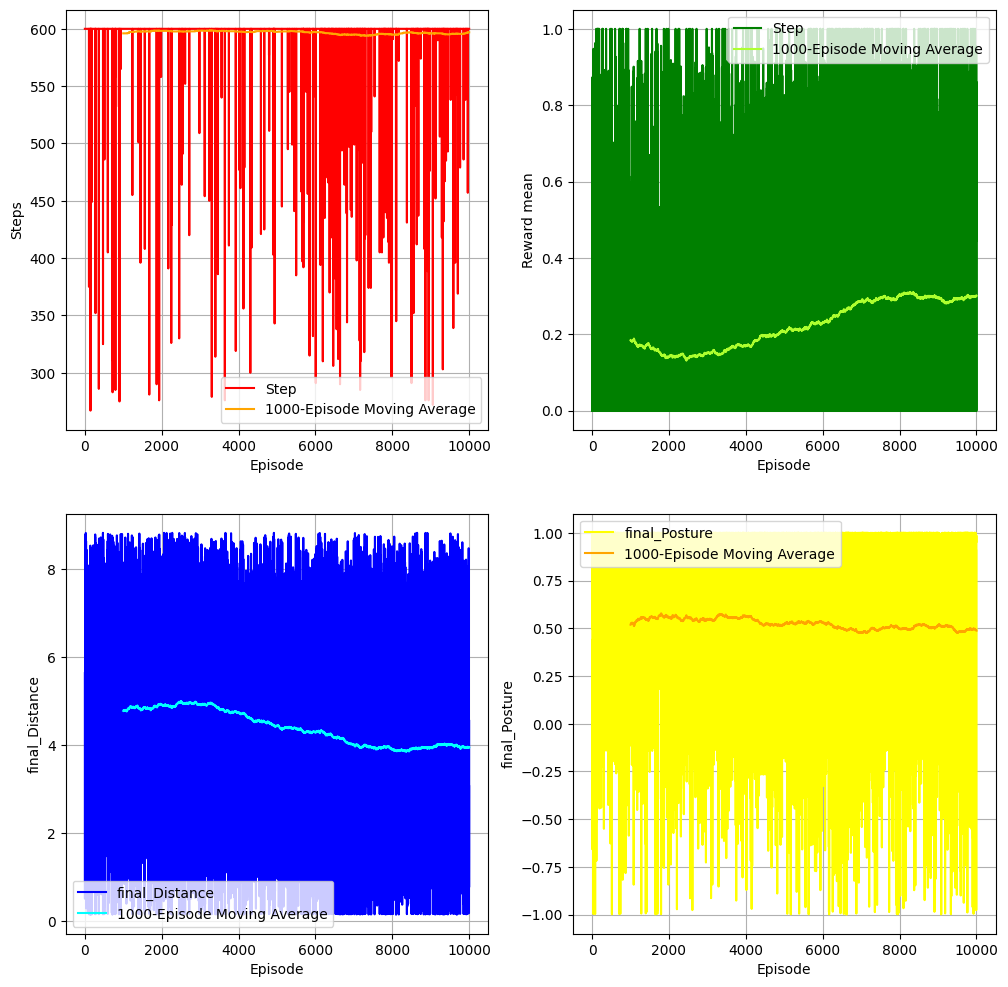

In [521]:
# 移動平均を計算する窓サイズを設定
window_size = 1000

# 報酬の移動平均を計算
reward_ma = np.convolve(sum_reward, np.ones(window_size)/window_size, mode='valid')

# ステップの移動平均を計算
step_ma = np.convolve(memory_step, np.ones(window_size)/window_size, mode='valid')

distance_ma = np.convolve(memory_distance, np.ones(window_size)/window_size, mode='valid')

theta_ma = np.convolve(memory_theta, np.ones(window_size)/window_size, mode='valid')

# プロットを作成
fig, axes = plt.subplots(2, 2, figsize=(12, 12))


# 最終step数の推移
axes[0,0].plot(episode_count, memory_step, color="red", label="Step")
axes[0,0].plot(episode_count[window_size-1:], step_ma, color="orange", label=f"{window_size}-Episode Moving Average")
axes[0,0].grid()
axes[0,0].set_xlabel("Episode")
axes[0,0].set_ylabel("Steps")
axes[0,0].legend(loc='lower right')

# 報酬の推移
axes[0,1].plot(episode_count, sum_reward, color="green", label="Step")
axes[0,1].plot(episode_count[window_size-1:], reward_ma, color="greenyellow", label=f"{window_size}-Episode Moving Average")
axes[0,1].grid()
axes[0,1].set_xlabel("Episode")
axes[0,1].set_ylabel("Reward mean")
axes[0,1].legend(loc='upper right')

# 最終的な距離の推移
axes[1,0].plot(episode_count, memory_distance, color="blue", label="final_Distance")
axes[1,0].plot(episode_count[window_size-1:], distance_ma, color="cyan", label=f"{window_size}-Episode Moving Average")
axes[1,0].grid()
axes[1,0].set_xlabel("Episode")
axes[1,0].set_ylabel("final_Distance")
axes[1,0].legend(loc='lower left')

# 最終的な姿勢の推移
axes[1,1].plot(episode_count, memory_theta, color="yellow", label="final_Posture")
axes[1,1].plot(episode_count[window_size-1:], theta_ma, color="orange", label=f"{window_size}-Episode Moving Average")
axes[1,1].grid()
axes[1,1].set_xlabel("Episode")
axes[1,1].set_ylabel("final_Posture")
axes[1,1].legend(loc='upper left')

plt.savefig("img_Q/result.png")


In [522]:
# import json
# import datetime

# dt_now = datetime.datetime.now()

# with open("./settings.json", "r", encoding="utf-8") as f:
#         j = json.load(f)

# token = j["LINE_token"]["my_token"]

# if NOTIFI:
#         bot = LINENotifyBot(access_token = token)
#         bot.send(
#         message="トレーニング完了 \n "
#                 +"Data:"+str(dt_now)+"\n"
#                 +"ENV:"+str(ENV)+"\n"
#                 +"CRITERION:"+str(CRITERION)+"\n"
#                 +"GAMMA:"+str(GAMMA)+"\n"
#                 +"LEARNING_RATE:"+str(LEARNING_RATE)+"\n"
#                 +"MAX_STEPS:"+str(MAX_STEPS)+"\n"
#                 +"MAX_STEPS:"+str(NUM_EPISODES)+"\n"
#                 +"BATCH_SIZE:"+str(BATCH_SIZE)+"\n"
#                 +"CAPACITY:"+str(CAPACITY)+"\n"
#                 +"UPDATE_FREQ:"+str(UPDATE_FREQ)+"\n"
#                 +"NUM_NEURON:"+str(MODELS)+"\n"
#                 ,
#         image='img/test.png'
# )

# 推論

In [523]:
# inference_env = Environment()
# model_path = 'models/model.pth'

# inference_env.agent.inference_dqn(model_path)
# inference_env.inference()



# メモ
## 改造案
- 台形内にボール座標が含まれたら，Roombaの中心座標からの相対座標を返す．台形外なら-1．
- 中間層を増やす．